In [1]:
import sys
import os
# Add parent directory to Python path so 'ridge_utils' can be imported
sys.path.append(os.path.abspath(".."))

import pickle

with open('../data/raw_text.pkl', 'rb') as file:
    raw_text = pickle.load(file)

/var/tmp/ipykernel_11721/819992315.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(file)


In [2]:
texts = []
story_names = []
text_dic = {}

for name, sequence in raw_text.items():
    try:
        text = sequence.data
        text = ' '.join(text)
        texts.append(text)
        story_names.append(name)
        text_dic[name] = text
    except Exception as e:
        print(f"Could not extract text for {name}: {e}")

In [3]:
import data
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader, Subset

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = data.TextDataset(texts, tokenizer, max_len=32)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

/jet/home/xliang8/.conda/envs/env_214/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
for batch in dataloader:
    print(batch)
    break

{'input_ids': tensor([[  101,  2061,  1045,  1005,  1049,  2012,  2023,  2283,  2067,  2188,
          1999, 11334,  5135,  1996,  1996,  3944,  1005,  1055, 12788,  2091,
          1998,  1045,  1005,  1049,  6069,  3046,  2000, 13583,  2041,  2043,
          2023,   102],
        [  101,  2061,  2009,  4627,  1999, 11977, 12021,  3157,  1998,  2009,
          1005,  1055,  2251,  1998,  1045,  1005,  1049,  2006,  2778,  2007,
          2026,  2316,  1998,  2057,  1005,  2128,  6828,  2083,  2885,  1998,
          2023,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [5]:
from encoder import Encoder
from train_encoder import train_bert

In [6]:
import yaml
import numpy as np
import torch
import itertools
from copy import deepcopy
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# Load config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# Split dataset
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# param grid
param_grid = {
    'lr': [1e-4, 3e-4, 5e-4, 1e-3],
    'hidden_size': [128, 256],
    'num_heads': [2, 4, 8],
    'num_layers': [2, 4, 8],
}
param_names = list(param_grid.keys())
param_combinations = list(itertools.product(*param_grid.values()))

# grid search
results = []
best_val_loss = float('inf')
best_params = None

best_train_losses=None
best_val_losses=None
for values in param_combinations:
    current_config = deepcopy(config)
    for k, v in zip(param_names, values):
        if k in current_config['model']:
            current_config['model'][k] = v
        elif k in current_config['optimizer']:
            current_config['optimizer'][k] = v

    model = Encoder(
        vocab_size=tokenizer.vocab_size,
        hidden_size=current_config['model']['hidden_size'],
        num_heads=current_config['model']['num_heads'],
        num_layers=current_config['model']['num_layers'],
        intermediate_size=current_config['model']['intermediate_size'],
        max_len=current_config['data']['max_len']
    )

    train_loader = DataLoader(train_dataset, batch_size=current_config['dataloader']['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=current_config['dataloader']['batch_size'])

    train_losses, val_losses = train_bert(
        model, train_loader, val_loader, tokenizer,
        epochs=current_config['trainer']['epochs'],
        lr=current_config['optimizer']['lr'],
        verbose=False
    )
    # calculate the average loss of last 10 epoch
    final_val_loss  = sum(val_losses[-10:]) / 10
    result_entry = {
        'params': dict(zip(param_names, values)),
        'val_loss': float(final_val_loss)
    }
    results.append(result_entry)

    print(f"Params: {result_entry['params']}, Val Loss: {final_val_loss:.4f}")

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = result_entry
        best_train_losses = train_losses
        best_val_losses = val_losses
        torch.save(model.state_dict(), 'best_model_from_grid.pt')

# save yaml
with open('grid_search_results.yaml', 'w') as f:
    yaml.dump(results, f)

print("\nBest Params:")
print(best_params['params'])
print(f"Best Validation Loss: {best_params['val_loss']:.4f}")

best_config = deepcopy(config)

for key, value in best_params['params'].items():
    if key in best_config.get('model', {}):
        best_config['model'][key] = value
    elif key in best_config.get('optimizer', {}):
        best_config['optimizer'][key] = value

best_config['grid_search'] = {
    'best_val_loss': float(best_val_loss),
    'best_params': best_params['params']
}

with open('best_config.yaml', 'w') as f:
    yaml.dump(best_config, f)

print("Best config has been saved to best_config.yaml")


Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 2, 'num_layers': 2}, Val Loss: 8.7591
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 2, 'num_layers': 4}, Val Loss: 8.8145
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 2, 'num_layers': 8}, Val Loss: 8.6748
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 4, 'num_layers': 2}, Val Loss: 8.9958
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 4, 'num_layers': 4}, Val Loss: 8.7940
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 4, 'num_layers': 8}, Val Loss: 8.7204
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 8, 'num_layers': 2}, Val Loss: 9.0232
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 8, 'num_layers': 4}, Val Loss: 8.9066
Params: {'lr': 0.0001, 'hidden_size': 128, 'num_heads': 8, 'num_layers': 8}, Val Loss: 8.7047
Params: {'lr': 0.0001, 'hidden_size': 256, 'num_heads': 2, 'num_layers': 2}, Val Loss: 7.9362
Params: {'lr': 0.0001, 'hidden_size': 256, 'num_heads': 2, '

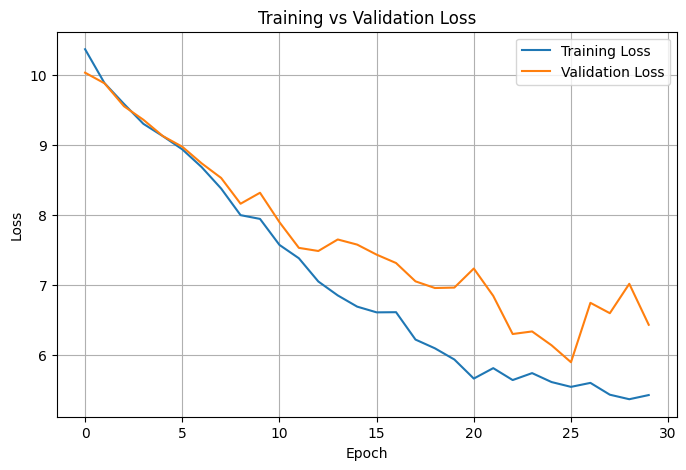

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def save_embeddings(model_path, dataloader, tokenizer, device='cuda', output_path='embeddings.pt', best_config=None):
    model = Encoder(
        vocab_size=tokenizer.vocab_size,
        hidden_size=best_config['model']['hidden_size'],
        num_heads=best_config['model']['num_heads'],
        num_layers=best_config['model']['num_layers'],
        intermediate_size=best_config['model']['intermediate_size'],
        max_len=best_config['data']['max_len']
    ).to(device)


    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_token_embeddings_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            embeddings = model(input_ids, token_type_ids, attention_mask, return_embeddings=True)
            all_token_embeddings  = embeddings
            all_token_embeddings_list.append(all_token_embeddings.cpu())

    all_token_embeddings  = torch.cat(all_token_embeddings_list, dim=0)
    torch.save(all_token_embeddings , output_path)
    print(all_token_embeddings.shape)
    print(f"Saved {all_token_embeddings .shape[0]} embeddings to {output_path}")

In [10]:
# Redefine loaders based on best config
train_loader = DataLoader(train_dataset, batch_size=best_config["dataloader"]["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_config["dataloader"]["batch_size"])

# Save embeddings using best model + best config
save_embeddings(
    model_path='best_model_from_grid.pt',
    dataloader=train_loader,
    tokenizer=tokenizer,
    output_path='train_embeddings.pt',
    best_config=best_config
)

save_embeddings(
    model_path='best_model_from_grid.pt',
    dataloader=val_loader,
    tokenizer=tokenizer,
    output_path='test_embeddings.pt',
    best_config=best_config
)


torch.Size([87, 32, 128])
Saved 87 embeddings to train_embeddings.pt
torch.Size([22, 32, 128])
Saved 22 embeddings to test_embeddings.pt


In [11]:
train_embeddings = torch.load('train_embeddings.pt')
test_embeddings = torch.load('test_embeddings.pt')

print(train_embeddings.shape)
print(test_embeddings.shape)

torch.Size([87, 32, 128])
torch.Size([22, 32, 128])


In [12]:
train_story_indices = train_dataset.indices
test_story_indices = val_dataset.indices 
train_stories = [story_names[i] for i in train_story_indices]
test_stories = [story_names[i] for i in test_story_indices]
train_vecs = {
    story: train_embeddings[i].cpu().numpy()
    for i, story in enumerate(train_stories)
}
test_vecs = {
    story: test_embeddings[i].cpu().numpy()
    for i, story in enumerate(test_stories)
}

In [ ]:
import preprocessing as prep

keys = list(raw_text.keys())
train_keys = [keys[i] for i in train_story_indices]
train_data = {key: raw_text[key] for key in train_keys}
wordseqs_train = {}  # initialize once before the loop
for story, ds in train_data.items():
    wordseqs_train[story] = ds

downsampled_train = prep.downsample_embeddings(train_stories, train_vecs, wordseqs_train)

test_keys = [keys[i] for i in test_story_indices]
test_data = {key: raw_text[key] for key in test_keys}
wordseqs_test = {}  # initialize once before the loop
for story, ds in test_data.items():
    wordseqs_test[story] = ds
    
downsampled_test = prep.downsample_embeddings(test_stories, test_vecs, wordseqs_test)

In [ ]:
# Parameters
trim_front = 5
trim_back = 10
delays = [1, 2, 3, 4]

datasets = {
    "train": downsampled_train,
    "test": downsampled_test
}

subjects = {
    "subject2": "/ocean/projects/mth240012p/shared/data/subject2",
    "subject3": "/ocean/projects/mth240012p/shared/data/subject3"
}

for dataset_name, dataset in datasets.items():
    for subject_name, voxel_dir in subjects.items():
        print(f"\n==============================")
        print(f"Checking {dataset_name.upper()} — {subject_name.upper()}")
        print(f"==============================")

        for story in dataset:
            trimmed_x = dataset[story][trim_front : -trim_back, :]
            delayed_x = prep.make_delayed(trimmed_x, delays=delays)
            x_len = delayed_x.shape[0]

            y_path = os.path.join(voxel_dir, f"{story}.npy")
            if os.path.exists(y_path):
                Y = np.load(y_path)
                y_len = Y.shape[0]

                if x_len == y_len:
                    print(f"Match: {story}")
                else:
                    print(f"\nMismatch: {story}")
                    print(f"X shape: {delayed_x.shape}")
                    print(f"Y shape: {Y.shape}")
            else:
                print(f"{story} — Voxel file not found in {subject_name}")



Checking TRAIN — SUBJECT2
Match: theadvancedbeginner
Match: superheroesjustforeachother
Match: seedpotatoesofleningrad
Match: mayorofthefreaks
Match: adollshouse
Match: cautioneating
Match: haveyoumethimyet
Match: ifthishaircouldtalk
Match: myfathershands
Match: thecurse
Match: hangtime
Match: breakingupintheageofgoogle
Match: theclosetthatateeverything
Match: leavingbaghdad
myfirstdaywiththeyankees — Voxel file not found in subject2
Match: itsabox
Match: golfclubbing
Match: odetostepfather
Match: gpsformylostidentity
Match: exorcism
Match: waitingtogo
Match: theinterview
dialogue6 — Voxel file not found in subject2
Match: forgettingfear
dialogue5 — Voxel file not found in subject2
Match: shoppinginchina
Match: swimmingwithastronauts
Match: singlewomanseekingmanwich
Match: comingofageondeathrow
Match: howtodraw
Match: canplanetearthfeedtenbillionpeoplepart2
Match: learninghumanityfromdogs
Match: eyespy
Match: bluehope
Match: cocoonoflove
dialogue3 — Voxel file not found in subject2
di